In [2]:
import json
import numpy as np
import os
from PIL import Image, ImageDraw
from collections import defaultdict

from matplotlib import pyplot as plt
from matplotlib import animation as animation

In [4]:
path = "/data/users/jmorales/model_files/DRAM/DRAM_SVHN_expand_110x110_std0_03_lr0_0001"
res_file = [i for i in os.listdir(path) if "results.json" in i][0]
res_file = os.path.join(path, res_file)

with open(res_file, "r") as f:
    results = json.load(f)

In [5]:
total_per_digit = defaultdict(lambda: 0)
correct_per_digit = defaultdict(lambda: 0)
correct_per_digit_no_end = defaultdict(lambda: 0)
reward_per_digit = defaultdict(list)
for res in results:
    num_digits = (np.array(res["labels"]) != -100).sum()
    correct_num_digits_no_end =  ((np.array(res["pred"]) != -100) * ((np.array(res["pred"]) != 0))).sum()
    correct = res["all_correct"]
    reward = res["reward"]
    # how many fail predicting end?

    total_per_digit[num_digits] += 1
    correct_per_digit[num_digits] += correct
    correct_per_digit_no_end[num_digits] += correct_num_digits_no_end == (num_digits-1)
    reward_per_digit[num_digits].append(reward)

In [6]:
def show_labels(ax, y):
    # Make some labels.
    labels = [f"{i:.3f}" for i in y]
    rects = ax.patches
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
        )

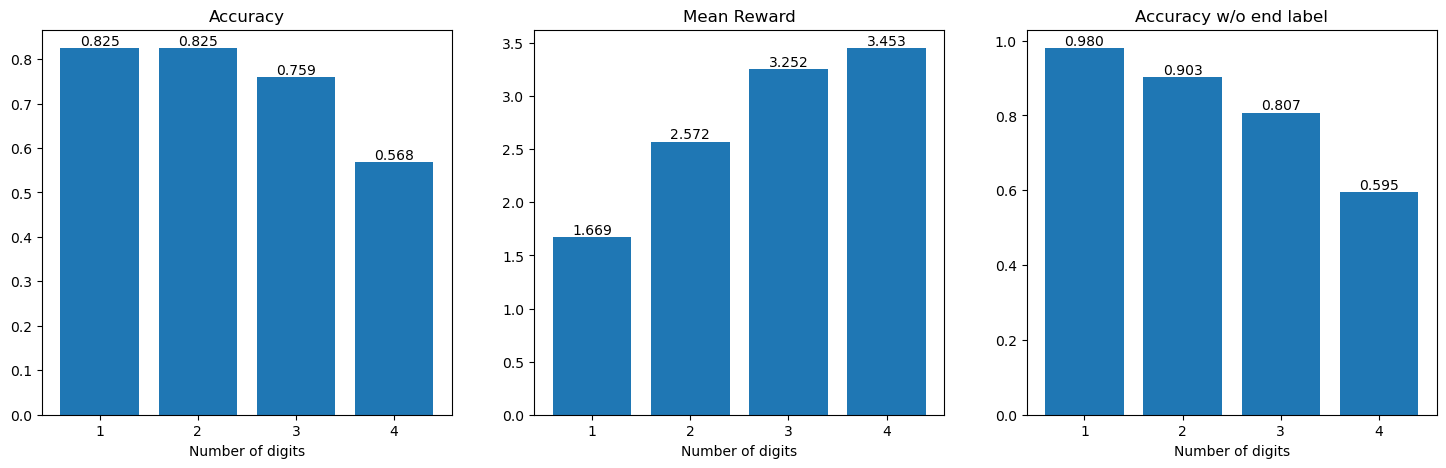

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

x = [i-1 for i in range(2, 6)]
y1 = [correct_per_digit[i] / total_per_digit[i] for i in range(2, 6)]
y2 = [np.mean(reward_per_digit[i]) for i in range(2, 6)]
y3 = [correct_per_digit_no_end[i] / total_per_digit[i] for i in range(2, 6)]

ax[0].bar(x, y1)
ax[0].set_xticks(x)
ax[0].set_title("Accuracy")
ax[0].set_xlabel("Number of digits")
show_labels(ax[0], y1)


ax[1].bar(x, y2)
ax[1].set_xticks(x)
ax[1].set_title("Mean Reward")
ax[1].set_xlabel("Number of digits")
show_labels(ax[1], y2)


ax[2].bar(x, y3)
ax[2].set_xticks(x)
ax[2].set_title("Accuracy w/o end label")
ax[2].set_xlabel("Number of digits")
show_labels(ax[2], y3)

### Visualizing glimpses

In [19]:
def create_gif(img, locs, num_glimpses, patch_size, colors, resize_factor, out_file):
    # create draw object
    gif_image = img.copy()
    line_draw = ImageDraw.Draw(gif_image)

    frames = []
    for i in range(len(locs)):
        # get color for current glimpse
        current_color = colors[i//num_glimpses]
        point = locs[i]

        if i != 0:
            # All frames share the drawing of the line connecting glimpses
            line_draw.line((*prev_point, *point), fill="white")

        # In each frame only one glimpse will be visible, 
        frame = gif_image.copy()
        frame_draw = ImageDraw.Draw(frame)

        # draw center glimpse point
        frame_draw.point(point, fill=current_color)

        # draw an small circle around the center glimpse point (for better visibility)
        radius = 5
        shape = [(point[0]-radius, point[1]-radius), (point[0]+radius, point[1]+radius)]
        frame_draw.ellipse(shape, outline=current_color)

        # draw the area covered by the glimpse
        radius = patch_size/2 * resize_factor
        shape = [(point[0]-radius, point[1]-radius), (point[0]+radius, point[1]+radius)]
        frame_draw.rectangle(shape, outline=current_color)

        # update previous point
        prev_point = point
        
        # save frame
        frames.append(frame)

    # Set the initial frame
    fig, ax = plt.subplots()
    im = ax.imshow(frames[0], animated=True)

    def update(i):
        im.set_array(frames[i])
        return im

    # Create the animation (GIF)
    animation_fig = animation.FuncAnimation(
        fig, update, frames=len(frames), interval=400, blit=False, repeat_delay=200)
    animation_fig.save(out_file)

    return frames


def visualize_glimpses(sample, patch_size, num_glimpses, save_gif=False, out_file=None):
    # Number of correctly pred
    pred_digits = np.array(sample["pred"])[(np.array(sample["pred"]) != -100)]
    pred_digits = [i if i != 0 else "end" for i in pred_digits]
    correct_num_digits = (np.array(sample["pred"]) != -100).sum()
    gt_labels = np.array(sample['labels'])[(np.array(sample["labels"]) != -100)]
    gt_labels = [i if i != 0 else "end" for i in gt_labels]

    print(f"GT: {gt_labels}")
    print(f"Predicted digits: {pred_digits}")

    # load image and normalize
    img = np.array(sample["pixel_values"])
    img = (img * 0.3081) + 0.1307
    img = np.repeat(img, 3, axis=0)
    img = np.moveaxis(img, 0, 2)
    img = Image.fromarray(np.uint8(img*255))
    w, h = img.size
    

    # Resize to be visible
    resize_factor = 5
    img = img.resize((w*resize_factor, h*resize_factor))
    w, h = img.size

    # convert glimpse locations to pixel space
    locs = [[(i + 1)/2 * w, (j + 1)/2 * h] for i,j in sample["locs"]]
    locs = locs[:correct_num_digits*num_glimpses]

    # colors to distinguish digit predictions
    colors = ["red", "blue", "yellow", "green", "orange"]

    # create draw object
    draw_img = img.copy()
    draw = ImageDraw.Draw(draw_img)

    for i in range(len(locs)):
        # get color for current glimpse
        current_color = colors[i//num_glimpses]
        
        # draw center glimpse point
        point = locs[i]
        draw.point(point, fill=current_color)

        if i != 0:
            # Line joining past and current glimpse
            draw.line((*prev_point, *point), fill="white")

        # draw an small circle around the center glimpse point (for better visibility)
        radius = 5
        shape = [(point[0]-radius, point[1]-radius), (point[0]+radius, point[1]+radius)]
        draw.ellipse(shape, outline=current_color)

        # draw the area covered by the glimpse
        radius = patch_size/2 * resize_factor
        shape = [(point[0]-radius, point[1]-radius), (point[0]+radius, point[1]+radius)]
        draw.rectangle(shape, outline=current_color)

        # update previous point
        prev_point = point

    if save_gif:
        create_gif(img, locs, num_glimpses, patch_size, colors, resize_factor, out_file)

    return draw_img


In [14]:
path = "/data/users/jmorales/model_files/DRAM/DRAM_SVHN_expand_110x110_std0_03_lr0_0001"
res_file = [i for i in os.listdir(path) if "results.json" in i][0]
res_file = os.path.join(path, res_file)

with open(res_file, "r") as f:
    results = json.load(f)

GT: [9, 'end']
Predicted digits: [9, 'end']


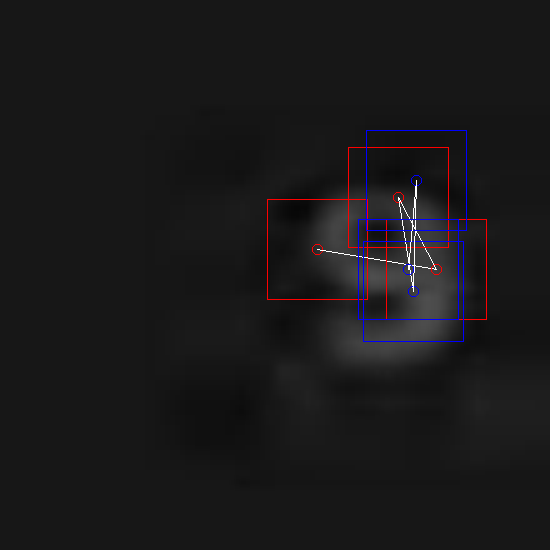

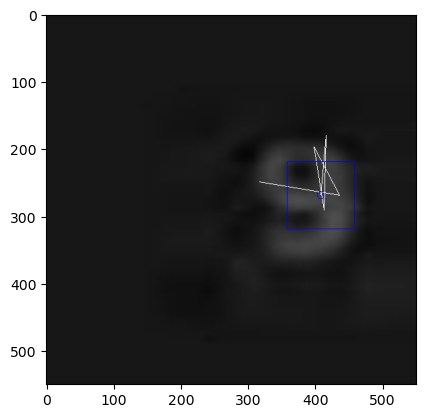

In [30]:
sample = results[4]

visualize_glimpses(
    sample, 
    patch_size=20, 
    num_glimpses=3, 
    save_gif=True, 
    out_file="../plots/glimpses110x110.gif")